In [3]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy import ndimage
from scipy.special import xlogy
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

In [4]:
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    """
    Parallel implementation of the laplacian operator with periodic boundary conditions.
    """
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc


@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    """
    Integrates the gray-scott system over time using the given initial
    conditions.
    """
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0, seed=5000000):
    """
    Wrapper function that initializes the U and V concentration arrays and the
    random number generator.
        
        n: dimensions of the discretized system
        F: value of F used for the model
        k: value of k used for the model
        T: number of time steps simulated
    
    """
    np.random.seed(seed=seed)
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    """
    Calculates the number and size of objects in a given array.
    
    An array is returned with the size of each object, the length of the 
    array thus being the number of objects. A [0] array is returned if
    no objects are found.
    """
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels2 = ndimage.label(binarized2, structure=s)
    if labels1[1] > labels2[1]:
        bins, edges = np.histogram(labels1[0], bins=labels1[1])
        return bins[1:]

    # Try inversed region
    if labels2[1] > 1:
        bins, edges = np.histogram(labels2[0], bins=labels2[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

# Shows the initial conditions of U and V

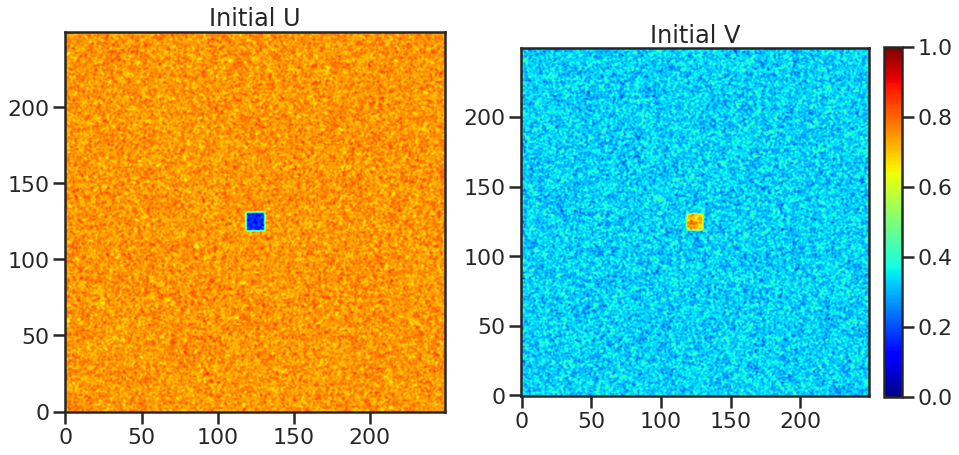

In [11]:
n=250
U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 1.0
V[m-r:m+r, m-r:m+r] = 0.25
U[m-r:m+r, m-r:m+r] = 0.5
U += np.random.normal(scale=0.05, size=U.shape)
V += np.random.normal(scale=0.05, size=V.shape)

# Rescale for colorbar
U = U - np.min(U)
U = U / np.max(U)

V = V - np.min(V)
V = V / np.max(V)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.set_title("Initial U")
ax2.set_title("Initial V")
im1 = ax1.imshow(U, origin='lower', interpolation='bicubic', cmap='jet')
im2 = ax2.imshow(V, origin='lower', interpolation='bicubic', cmap='jet')
fig.colorbar(im1,fraction=0.046, pad=0.04)
fig.savefig('Pics/systems/initial.png', bbox_inches='tight', dpi=150)
plt.show()

# Visualizations of the system during the first trajectory dots to chaos

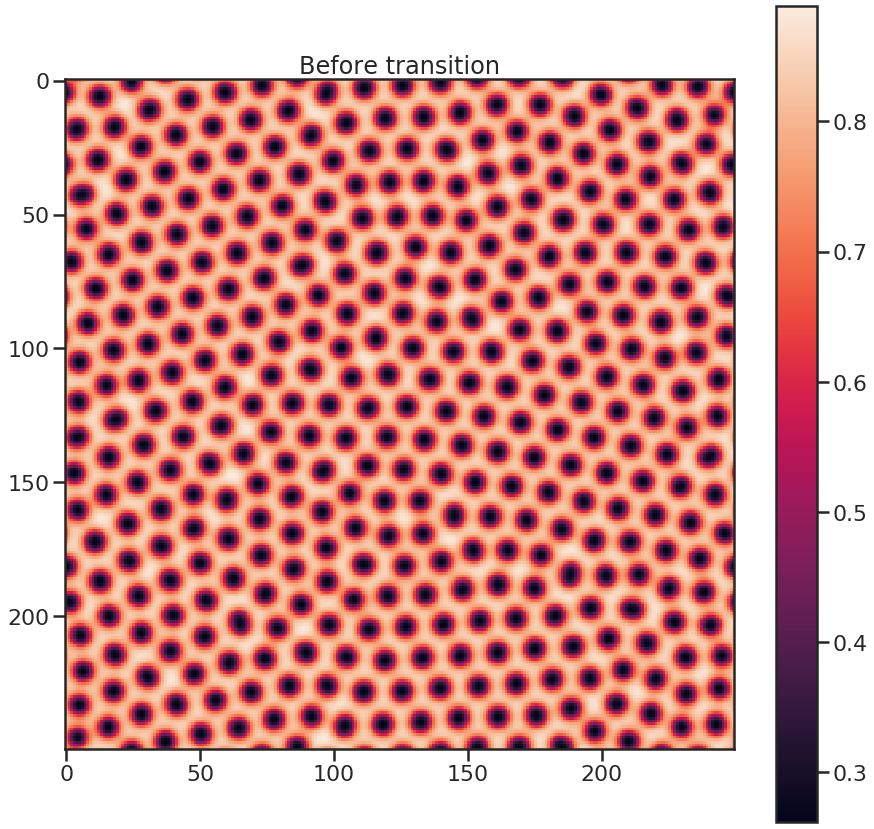

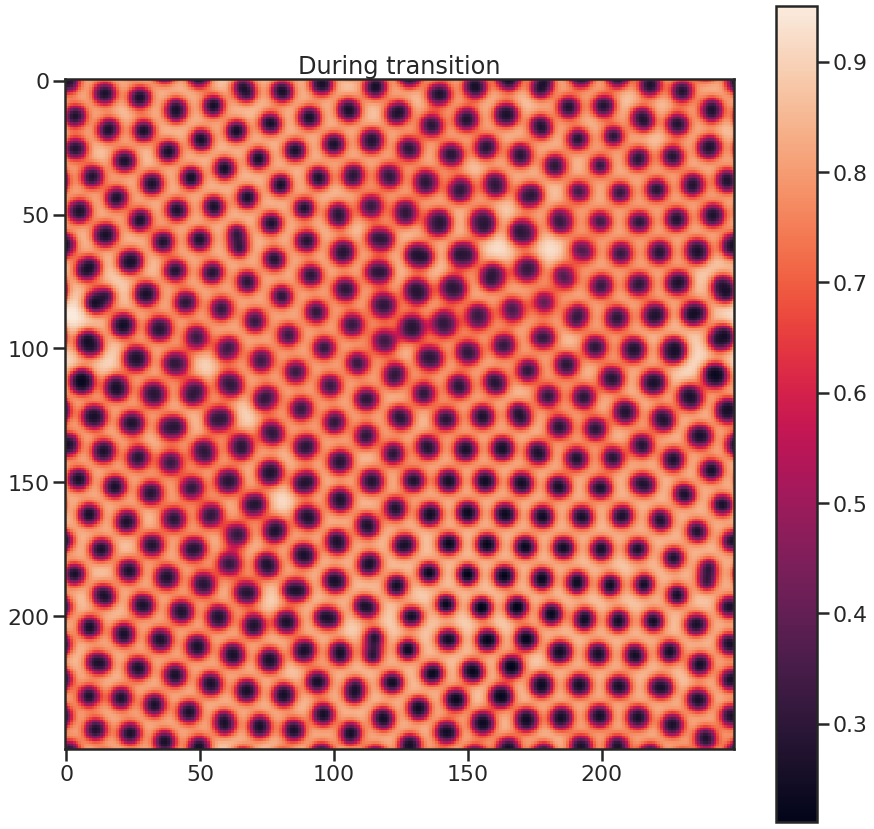

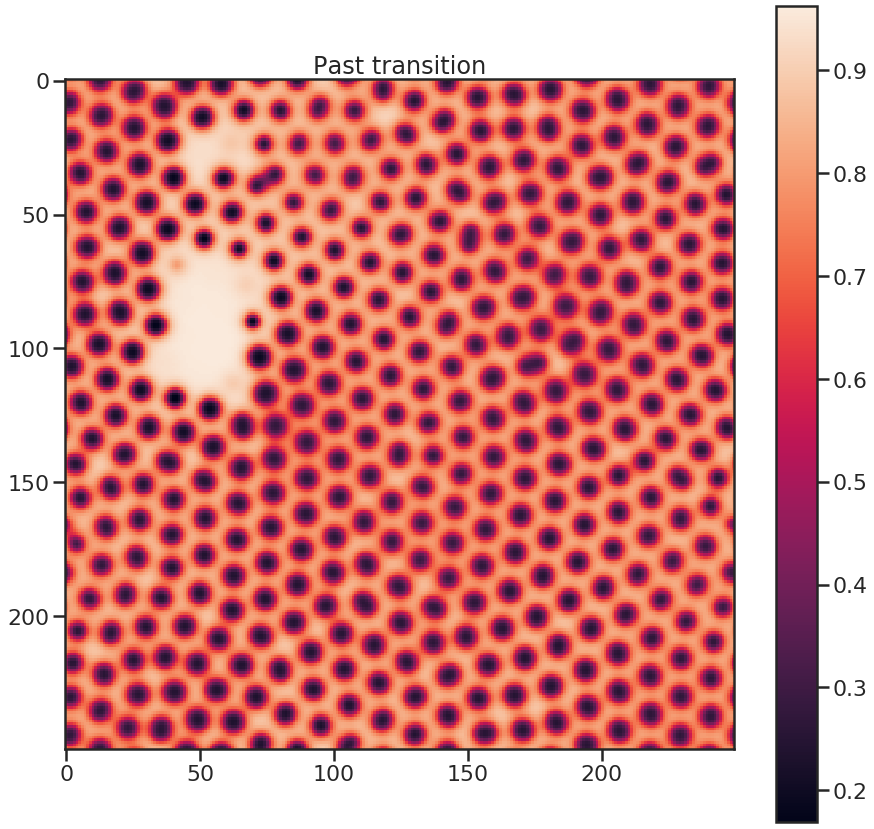

In [12]:
f = np.linspace(0.0271360, 0.0238191, 250)[::-1]
k = np.linspace(0.06141, 0.05869347, 250)[::-1]

plt.figure(figsize=(15,15))
plt.title("Before transition")
plt.imshow(gscott(250, f[249], k[249], 20000)[0])
plt.colorbar()
plt.savefig('Pics/systems/traj1_1.png', bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(15,15))
plt.title("During transition")
plt.imshow(gscott(250, f[136], k[136], 20000)[0])
plt.colorbar()
plt.savefig('Pics/systems/traj1_2.png', bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(15,15))
plt.title("Past transition")
plt.imshow(gscott(250, f[133], k[133], 20000)[0])
plt.colorbar()
plt.savefig('Pics/systems/traj1_3.png', bbox_inches='tight', dpi=150)
plt.show()

# Visualizations of the second trajectory dots to worms

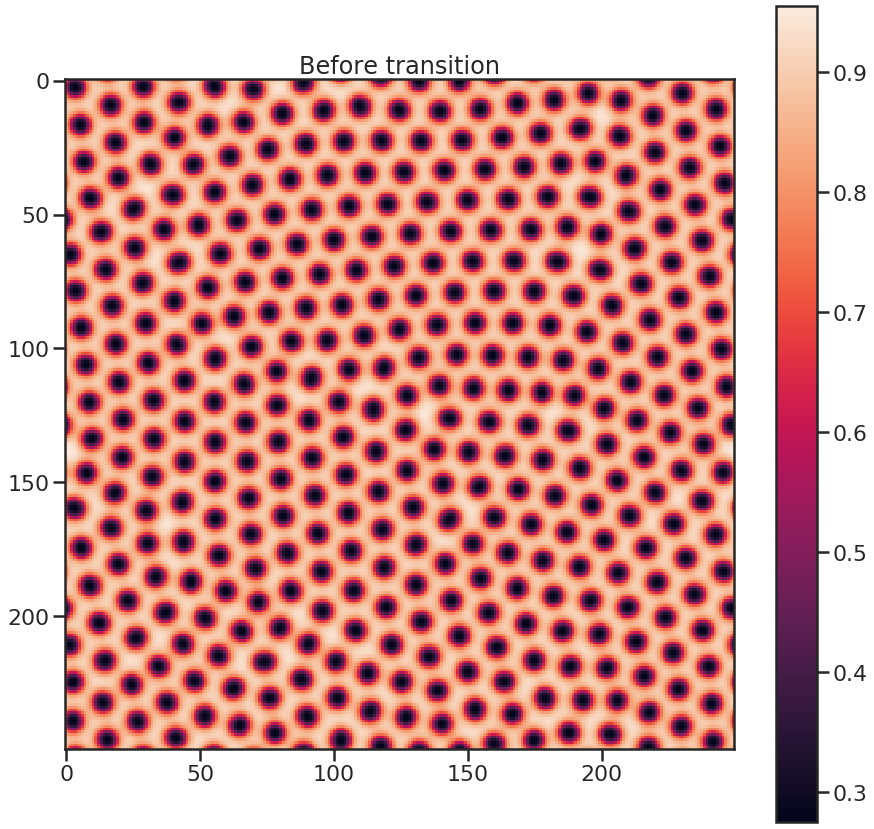

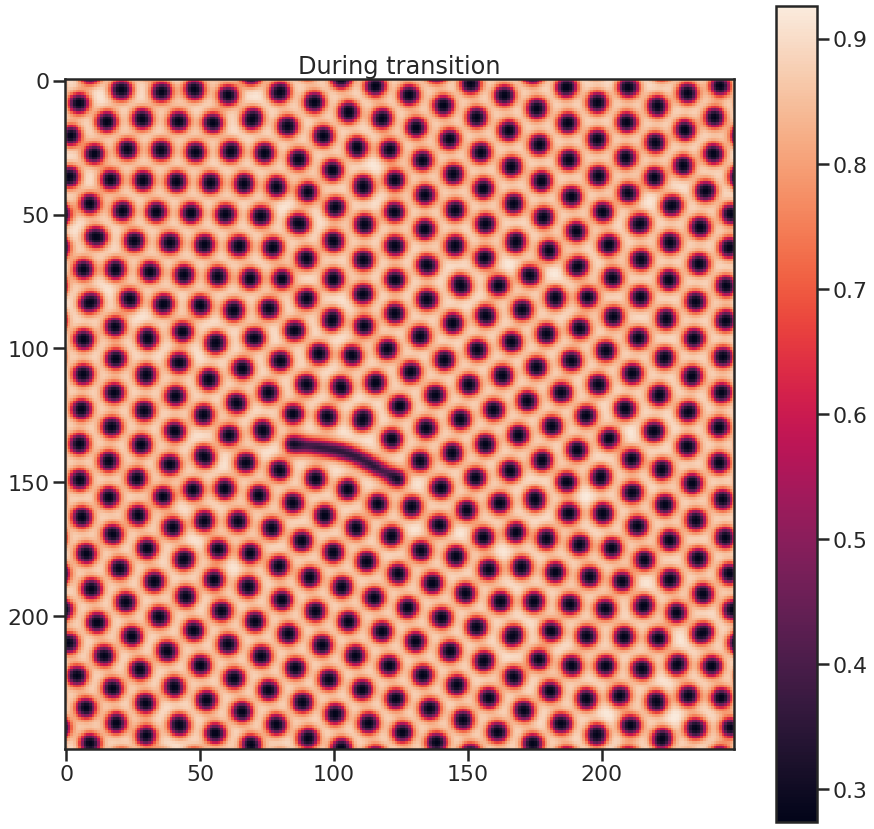

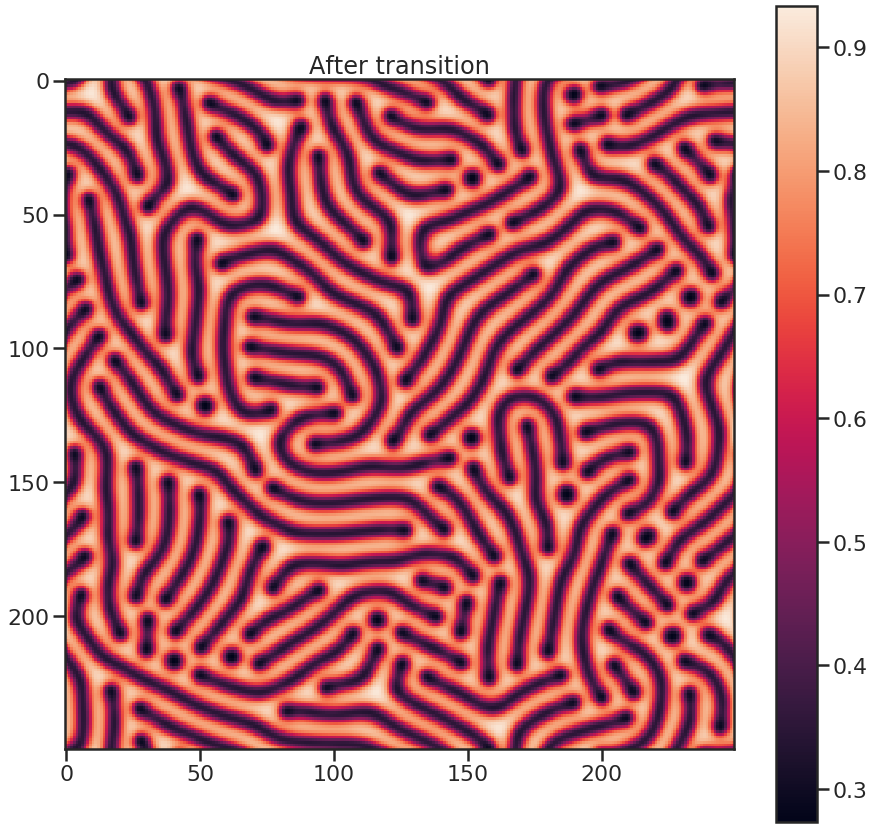

In [13]:
k = np.linspace(0.0652, 0.0632, 250)
f = np.linspace(0.0395, 0.04228, 250)

plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[0], k[0], 50000)[0])
plt.colorbar()
plt.title("Before transition")
plt.savefig('Pics/systems/traj2_1.png', bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[70], k[70], 50000)[0])
plt.colorbar()
plt.title("During transition")
plt.savefig('Pics/systems/traj2_2.png', bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[200], k[200], 50000)[0])
plt.colorbar()
plt.title("After transition")
plt.savefig('Pics/systems/traj2_3.png', bbox_inches='tight', dpi=150)
plt.show()